In [ ]:
import pandas as pd
import os

# https://github.com/Unipisa/admin-It/tree/main
data_path = "data/admin-It/"

def load_data(data_path, identifier):
    data_path += '/' if not data_path.endswith('/') else ''
    print('*', data_path)
    admin_it = pd.DataFrame()
    for filename in os.listdir(data_path):
        print('**', filename)
        if filename.endswith('comp.txt'):
            with open(data_path + filename, 'r', encoding='utf-8') as norm_f:
                #print(norm_f.readlines())
                normal =  list(line for line in (l.strip() for l in norm_f) if line)
            with open(data_path + filename.replace('comp.txt', 'simp.txt'), 'r', encoding='utf-8') as simp_f:
                #print(simp_f.readlines())
                simple =  list(line for line in (l.strip() for l in simp_f) if line)
            #print(normal)
            #print(simple)
            admin_it = pd.concat([pd.DataFrame({'normal_phrase': normal, 'simple_phrase':simple, 'source': identifier, 'file': filename}), admin_it])#.reset_index()
    return admin_it

admin_it_all = pd.concat([
    load_data(data_path + 'OP', 'OP'),
    load_data(data_path + 'RD', 'RD'),
    load_data(data_path + 'RS', 'RS')])
admin_it_all

In [17]:
admin_it_all.normal_phrase.values[20]

"Andrà evidenziata l'eventuale generazione di impatti negativi sul paesaggio."

In [14]:
admin_it_all.to_csv('data/admin_it_aligned.csv', index=False)

In [31]:
from transformers import pipeline

topic_pipe = pipeline("text2text-generation", model="mpapucci/it5-topic-classification-tag-it")
hate_pipe = pipeline("text-classification", model="IMSyPP/hate_speech_it")#"nickprock/setfit-italian-hate-speech")
emotion_pipe = pipeline("text-classification", model='MilaNLProc/feel-it-italian-emotion',top_k=1)
sentiment_pipe = pipeline("text-classification", model='neuraly/bert-base-italian-cased-sentiment')

In [33]:
sample = "Andrà evidenziata l'eventuale generazione di impatti negativi sul paesaggio."
print(topic_pipe("Classifica Argomento: " + sample))
print(hate_pipe(sample))
print(emotion_pipe(sample))
print(sentiment_pipe(sample))

[{'generated_text': 'automobilismo'}]
[{'label': 'LABEL_0', 'score': 0.9809191823005676}]
[[{'label': 'fear', 'score': 0.9909533262252808}]]
[{'label': 'neutral', 'score': 0.9827862977981567}]


In [26]:
topic_pipe.task

'text2text-generation'

## Generate Plots

In [12]:
colors = {
    #'sentiment': 'lightblue',
    #'hate_speech': 'orange',
    'topic': '#4daf4a',
    'emotion': '#377eb8',
    #'emotion_xlm': 'brown',
    'sentiment_feel': '#f781bf',#'sentiment_multiling': 'purple'
    #'emotion_reduced': 'orange'
}
labels = {
    'topic': 'Topic',
    'emotion': 'Emotion',
    'sentiment_feel': 'Sentiment',#'sentiment_multiling': 'purple'
    #'emotion_reduced': 'Emotion binary'
}
markers = {
    'emotion': '*',
    'topic': 'o',
    'sentiment_feel': 's',
    #'emotion_reduced': '^'
}

emotion_map = {"anger": "negative", "fear": "negative", "joy": "positive", "sadness": "negative"}

def compare_task(task, df):
    same_pred = []
    for n, s in zip(df[task.replace('_reduced', '') + '_normal'], df[task.replace('_reduced', '') + '_simple']):
        if type(n)==str and type(s) == str:
            if 'reduced' in task:
                same_pred.append(emotion_map[n.lower()]==emotion_map[s.lower()])
            else:
                same_pred.append(n.lower()==s.lower())
        else:
            same_pred.append(n==s)
    different = same_pred.count(False)
    error = round(100*different/len(same_pred), 2)
    print(f"**{task} error rate: {error}% with {len(same_pred)} samples")
    return error

def calculate_errors(df, column_name):
    print(column_name)
    errors_per_level = {}
    for simp, group in df.groupby(column_name):
        print('\n*', simp)
        df_tmp = {}
        for task in colors.keys():
            df_tmp[task] = compare_task(task, group)
        errors_per_level[simp] = df_tmp
    return errors_per_level

In [ ]:
import pandas as pd

admin_it = pd.read_csv('data/admin_it_aligned_pred.csv')
corpus_text_simp_pred = pd.read_csv('data/corpus_simp_it_pred.csv')
simpitiki_pred = pd.read_csv('data/simpitiki_pred.csv')
relevant_simplification_types = [1,2,3,32,33,34,35,36,37]
simpitiki_pred

In [14]:
def cut_whitespace(x: str):
    return str(x).split(' ')[0]

admin_it['topic_normal'] = admin_it['topic_normal'].apply(cut_whitespace)
admin_it['topic_simple'] = admin_it['topic_simple'].apply(cut_whitespace)
corpus_text_simp_pred['topic_normal'] = corpus_text_simp_pred['topic_normal'].apply(cut_whitespace)
corpus_text_simp_pred['topic_simple'] = corpus_text_simp_pred['topic_simple'].apply(cut_whitespace)
simpitiki_pred['topic_normal'] = simpitiki_pred['topic_normal'].apply(cut_whitespace)
simpitiki_pred['topic_simple'] = simpitiki_pred['topic_simple'].apply(cut_whitespace)

operations

* multi
**topic error rate: 12.16% with 148 samples
**emotion error rate: 27.03% with 148 samples
**sentiment_feel error rate: 8.11% with 148 samples

* single
**topic error rate: 6.63% with 588 samples
**emotion error rate: 9.69% with 588 samples
**sentiment_feel error rate: 3.23% with 588 samples


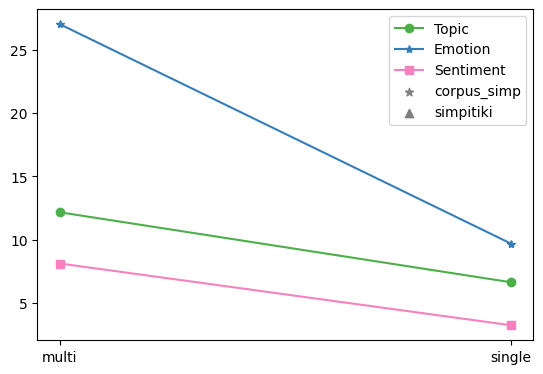

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.4, 4.3))
admin_it['operations'] = admin_it['source'].apply(lambda x: 'single' if x =='OP' else 'multi')
errors_per_level_admin = calculate_errors(admin_it, 'operations')

for task in colors.keys():
    plt.plot([level[task] for level in errors_per_level_admin.values()], label=labels[task], color=colors[task], marker=markers[task])
    #plt.scatter(2, compare_task(task, corpus_text_simp_pred), marker='*', color=colors[task])
    #plt.scatter(1, compare_task(task, simpitiki_pred[simpitiki_pred.type.isin(relevant_simplification_types)]), marker='^', color=colors[task])
    #plt.scatter(0, compare_task(task, simpitiki_pred), marker='^', color=colors[task])

plt.scatter([], [], marker='*', color='grey', label='corpus_simp')
plt.scatter([], [], marker='^', color='grey', label='simpitiki')

plt.xticks(range(len(errors_per_level_admin.keys())), labels=errors_per_level_admin.keys())
legend = plt.legend()
plt.show()

transformation

* phrase:
merge
**topic error rate: 0.0% with 22 samples
**emotion error rate: 4.55% with 22 samples
**sentiment_feel error rate: 0.0% with 22 samples

* phrase:
reorder
**topic error rate: 17.65% with 34 samples
**emotion error rate: 2.94% with 34 samples
**sentiment_feel error rate: 5.88% with 34 samples

* phrase:
split
**topic error rate: 10.53% with 38 samples
**emotion error rate: 15.79% with 38 samples
**sentiment_feel error rate: 5.26% with 38 samples

* phrase:
transform
**topic error rate: 9.98% with 411 samples
**emotion error rate: 7.79% with 411 samples
**sentiment_feel error rate: 4.38% with 411 samples

* word:
delete
**topic error rate: 10.58% with 208 samples
**emotion error rate: 10.1% with 208 samples
**sentiment_feel error rate: 3.37% with 208 samples

* word:
insert
**topic error rate: 6.93% with 101 samples
**emotion error rate: 11.88% with 101 samples
**sentiment_feel error rate: 3.96% with 101 samples

* word:
subsitute
**topic error rate: 7.16% 

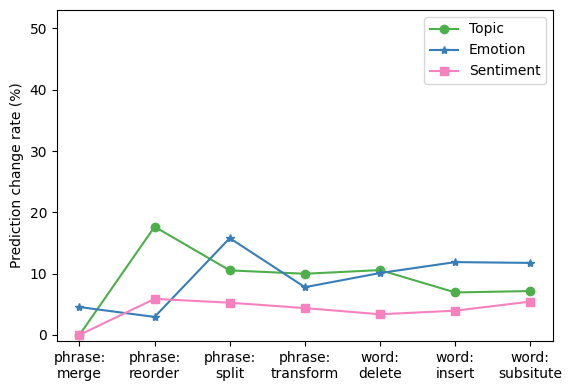

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.4, 4.3))
transformations = {
    1: 'phrase:\nsplit', 2: 'phrase:\nmerge', 3: 'phrase:\nreorder', 11: 'word:\ninsert', 12: 'word:\ninsert', 13: 'word:\ninsert', 21: 'word:\ndelete', 22: 'word:\ndelete', 23: 'word:\ndelete', 31: 'word:\nsubsitute',
    32: 'phrase:\ntransform', 33: 'phrase:\ntransform', 34: 'phrase:\ntransform', 35: 'phrase:\ntransform', 36: 'phrase:\ntransform', 37: 'phrase:\ntransform'
}

simpitiki_pred['transformation'] = simpitiki_pred['type'].apply(lambda x: transformations[x])

errors_per_level_simpitiki = calculate_errors(simpitiki_pred, 'transformation')

for task in colors.keys():
    plt.plot([level[task] for level in errors_per_level_simpitiki.values()], label=labels[task], color=colors[task], marker=markers[task])

plt.xticks(range(len(errors_per_level_simpitiki.keys())), labels=errors_per_level_simpitiki.keys())
legend = plt.legend()
plt.ylim(-1, 53)
#plt.show()
plt.ylabel('Prediction change rate (%)')
plt.savefig('plots_new/simpitiki_ops.pdf')

operations

* multi
**topic error rate: 18.8% with 1037 samples
**emotion error rate: 17.26% with 1037 samples
**sentiment_feel error rate: 10.8% with 1037 samples

* single
**topic error rate: 9.17% with 109 samples
**emotion error rate: 6.42% with 109 samples
**sentiment_feel error rate: 1.83% with 109 samples


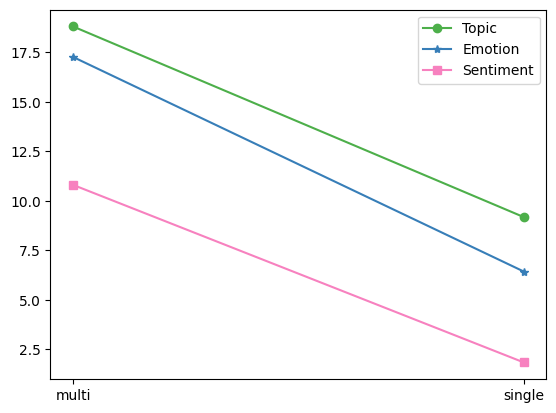

In [28]:
corpus_text_simp_pred = pd.read_csv('data/corpus_simp_it_pred.csv')

corpus_text_simp_pred['operations'] = corpus_text_simp_pred['simp_ops'].apply(lambda x: 'single' if x <=1 else 'multi')

errors_per_level_corpus = calculate_errors(corpus_text_simp_pred, 'operations')

for task in colors.keys():
    plt.plot([level[task] for level in errors_per_level_corpus.values()], label=labels[task], color=colors[task], marker=markers[task])

plt.xticks(range(len(errors_per_level_corpus.keys())), labels=errors_per_level_corpus.keys())
legend = plt.legend()
plt.show()

**topic error rate: 9.03% with 1163 samples
**emotion error rate: 9.8% with 1163 samples
**sentiment_feel error rate: 4.47% with 1163 samples


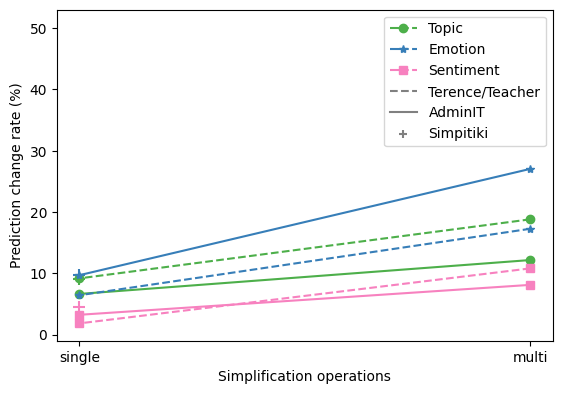

In [31]:
linestyles = {
    'corpus_simp': 'dashed',
    'admin_it': 'solid'
}

plt.figure(figsize=(6.4, 4.3))
for task in colors.keys():
    plt.plot([1, 0], [level[task] for level in errors_per_level_corpus.values()], color=colors[task], linestyle=linestyles['corpus_simp'], marker=markers[task])
    plt.plot([1, 0], [level[task] for level in errors_per_level_admin.values()], color=colors[task], linestyle=linestyles['admin_it'], marker=markers[task]) #switch order to match DEplain levels
    plt.scatter(0, compare_task(task, simpitiki_pred), marker='+', color=colors[task], s=70)

for task in colors.keys():
    plt.plot([], color=colors[task], linestyle='dashdot', label=labels[task], marker=markers[task])
plt.plot([], color='grey', label='Terence/Teacher', linestyle=linestyles['corpus_simp'])
plt.plot([], color='grey', label='AdminIT', linestyle=linestyles['admin_it'])
plt.scatter([], [], marker='+', color='grey', label='Simpitiki')

plt.ylim(-1, 53)
plt.xticks([0,1], ['single', 'multi'])
legend = plt.legend()
plt.ylabel('Prediction change rate (%)')
plt.xlabel('Simplification operations')
plt.savefig('plots_new/italian.pdf')
plt.show()

In [26]:
from tqdm import tqdm
from Levenshtein import distance, ratio
import matplotlib.pyplot as plt

distances = []
num_errors = []
aligned_combined = pd.concat([corpus_text_simp_pred, simpitiki_pred, admin_it])

for _, row in tqdm(aligned_combined.iterrows(), total=len(aligned_combined)):
    errors = 0
    for task in colors.keys():
        if 'reduced' in task:
            continue
        if row[task + '_normal'] != row[task + '_simple']:
            errors += 1
    num_errors.append(errors)
    distances.append(distance(row.normal_phrase, row.simple_phrase)/len(row.normal_phrase))#, score_cutoff=100))
    #distances.append(ratio(row.normal_phrase, row.simple_phrase))

100%|██████████| 3045/3045 [00:00<00:00, 11276.73it/s]


Text(0, 0.5, 'Levenshtein distance')

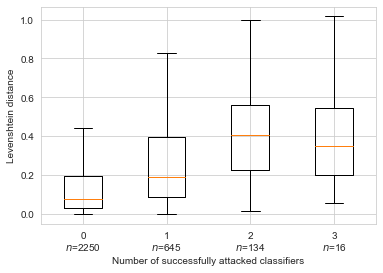

In [27]:
import numpy as np
dists = {
    0: np.array(distances)[np.array(num_errors) == 0].tolist(),
    1: np.array(distances)[np.array(num_errors) == 1].tolist(),
    2: np.array(distances)[np.array(num_errors) == 2].tolist(),
    3: np.array(distances)[np.array(num_errors) == 3].tolist(),
}

fig, ax = plt.subplots()
ax.boxplot(dists.values(), showfliers=False)
ax.set_xticklabels([f"{k}\n$n$={len(dists[k])}" for k in dists.keys()])
plt.xlabel("Number of successfully attacked classifiers")
plt.ylabel("Levenshtein distance")

In [28]:
import json
with open('lev_dist_italian.json', 'w') as fp:
    json.dump(dists, fp)

## Label distribution

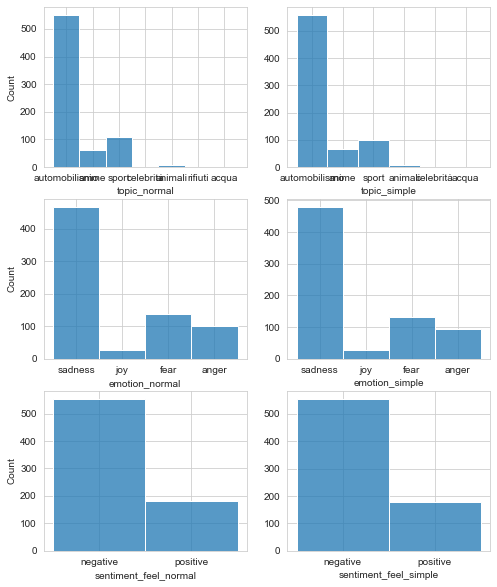

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

tasks = list(colors.keys())

fig, axs = plt.subplots(nrows=len(tasks), ncols=2, figsize=(8, 10))
for ax, task in zip(axs, tasks):
    for col, identifier in zip(ax, ['_normal', '_simple']):
        sns.histplot(data=admin_it[task + identifier],discrete=True, ax=col)  # RUN PLOT
        if col != ax[0]:
            col.set_ylabel('')
#plt.xlabel("Number of successfully attacked classifiers")
#plt.ylabel("Levenshtein ratio\noriginal $\\rightarrow$ simplified")
#plt.legend(loc="upper right")
plt.show()

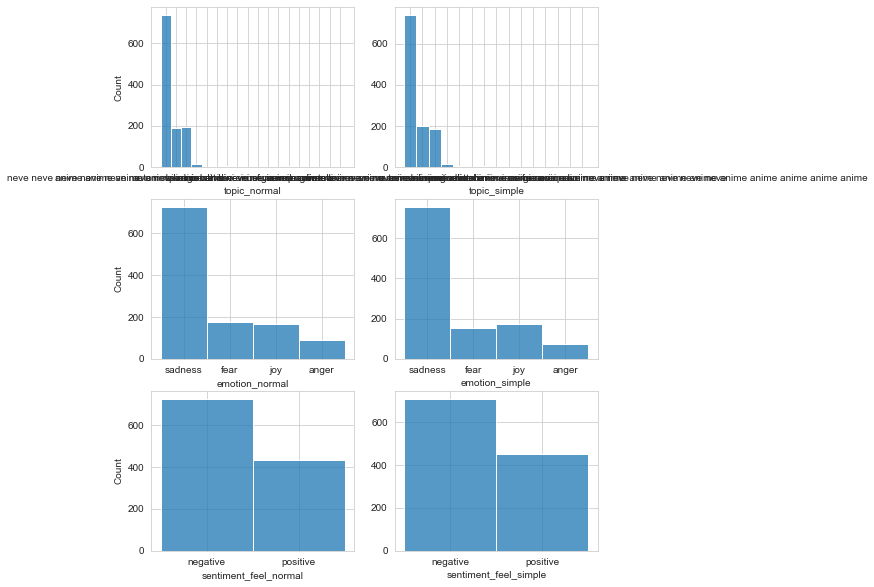

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

tasks = list(colors.keys())

fig, axs = plt.subplots(nrows=len(tasks), ncols=2, figsize=(8, 10))
for ax, task in zip(axs, tasks):
    for col, identifier in zip(ax, ['_normal', '_simple']):
        sns.histplot(data=simpitiki_pred[task + identifier],discrete=True, ax=col)  # RUN PLOT
        if col != ax[0]:
            col.set_ylabel('')
#plt.xlabel("Number of successfully attacked classifiers")
#plt.ylabel("Levenshtein ratio\noriginal $\\rightarrow$ simplified")
#plt.legend(loc="upper right")
plt.show()

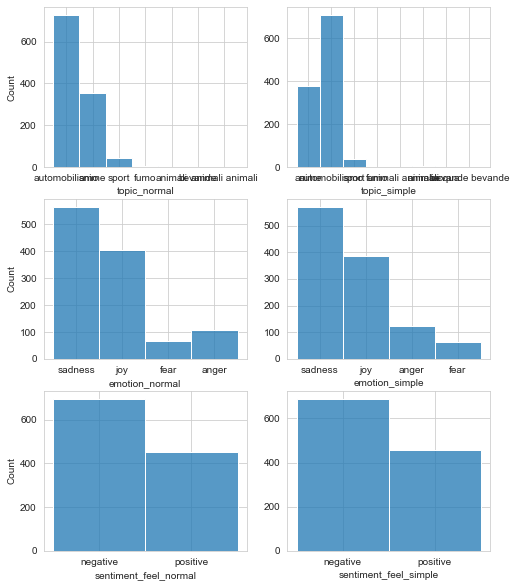

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

tasks = list(colors.keys())

fig, axs = plt.subplots(nrows=len(tasks), ncols=2, figsize=(8, 10))
for ax, task in zip(axs, tasks):
    for col, identifier in zip(ax, ['_normal', '_simple']):
        sns.histplot(data=corpus_text_simp_pred[task + identifier],discrete=True, ax=col)  # RUN PLOT
        if col != ax[0]:
            col.set_ylabel('')
#plt.xlabel("Number of successfully attacked classifiers")
#plt.ylabel("Levenshtein ratio\noriginal $\\rightarrow$ simplified")
#plt.legend(loc="upper right")
plt.show()

In [15]:
admin_it['topic_simple'].unique(), simpitiki_pred['topic_simple'].unique()

(array(['automobilismo', 'anime', 'sport', 'animali', 'celebrità', nan,
        'acqua'], dtype=object),
 array(['automobilismo', 'anime', 'sport', 'animali', 'giocattoli',
        'bambini', 'neve',
        'neve neve neve neve neve neve neve neve neve neve neve neve neve neve neve neve neve neve neve',
        'virus', 'energia', 'fumo', 'aerei', 'acqua', 'olio',
        'anime anime anime anime anime anime anime anime anime anime anime anime anime anime anime anime anime anime anime'],
       dtype=object))

In [12]:
corpus_text_simp_pred['topic_simple'].unique()

array(['anime', 'automobilismo', nan, 'sport', 'fumo', 'animali animali',
       'animali', 'acqua', 'bevande bevande'], dtype=object)

In [ ]:
duplicates_mapping = {'animali animali': 'animali'}